# LightGCN

## Import libraries

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from typing import Dict

from torch import nn, optim, Tensor, torch
from torch_geometric.utils.num_nodes import maybe_num_nodes

In [2]:
from data_loaders.data_loader_lightgcn import UserUserDatasetLightGCN
from light_gcn.light_gcn import LightGCN, bpr_loss, get_user_positive_items, RecallPrecision_ATk, NDCGatK_r, get_metrics, evaluation

In [3]:
torch.__version__

'2.1.1+cu118'

In [4]:
torch.device('cuda')

device(type='cuda')

In [5]:
print(torch.cuda.is_available()) 

False


/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Import data

In [6]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

## Create a UserUserDataset object for LightGCN model

In [7]:
uu_dataset_lightgcn = UserUserDatasetLightGCN(datasets_dict = datasets_dict, verbose = True)

Size of user-article interaction dataframe:  (895196, 6)
Number of unique users:  33703
Number of unique articles:  4351
Number of edges:  895196


In [8]:
train_edge_index, val_edge_index, test_edge_index = uu_dataset_lightgcn.get_train_test_val_split(val_split_ratio = 0.2, test_split_ratio = 0.5, random_state = 1, sparse = False)

Train edge index shape:  torch.Size([2, 716156])
Val edge index shape:  torch.Size([2, 89520])
Test edge index shape:  torch.Size([2, 89520])


In [9]:
source, target, negative_target = uu_dataset_lightgcn.get_negative_samples(train_edge_index)

In [10]:
user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(512)

# LightGCN: Run training loop

In [11]:
num_users, num_articles = uu_dataset_lightgcn.num_users, uu_dataset_lightgcn.num_articles
model = LightGCN(num_users, num_articles)

In [18]:
# define constants
ITERATIONS = 1000
BATCH_SIZE = 16 * 1024
LR = 1e-3
ITERS_PER_EVAL = 500
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [19]:
# setup
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = uu_dataset_lightgcn.edge_index.to(device)

train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = uu_dataset_lightgcn.train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = uu_dataset_lightgcn.val_sparse_edge_index.to(device)

Using device cpu.


In [20]:
# training loop
train_losses = []
val_losses = []
recall_list = []
precision_list = []
ndcg_list = []
hits_list = []

for iter in tqdm(range(ITERATIONS)):

    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = uu_dataset_lightgcn.get_random_mini_batches(BATCH_SIZE)

    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg, hits = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}, val_hits@{K}: {round(hits, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        recall_list.append(recall)
        precision_list.append(precision)
        ndcg_list.append(ndcg)
        hits_list.append(hits)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

33703


  0%|          | 1/1000 [00:12<3:24:10, 12.26s/it]

[Iteration 0/1000] train_loss: -157.85249, val_loss: -4.91676, val_recall@20: 0.08814, val_precision@20: 0.01914, val_ndcg@20: 0.04561, val_hits@20: 0.17826


 50%|█████     | 500/1000 [03:28<03:32,  2.35it/s]

33703


 50%|█████     | 501/1000 [03:44<40:09,  4.83s/it]

[Iteration 500/1000] train_loss: -258.21802, val_loss: -7.61435, val_recall@20: 0.08877, val_precision@20: 0.01918, val_ndcg@20: 0.04643, val_hits@20: 0.18396


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


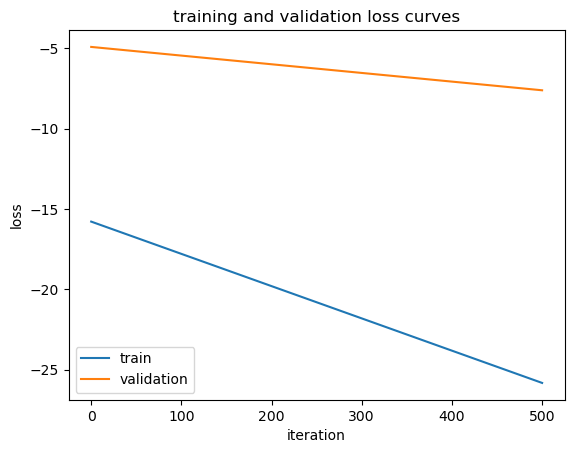

In [21]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, np.array(train_losses)/10, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

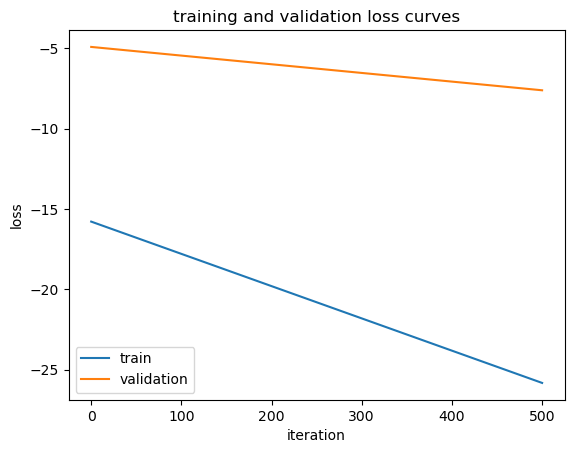

In [22]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, np.array(train_losses)/10, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

# GraphSage

## Import libraries

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import matplotlib.pyplot as plt 
import numpy as np 

import subprocess as sp
import os
from tqdm import tqdm


In [21]:
from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE

## Import data

In [ ]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

## Create UserUser dataset for GraphSAGE model

In [22]:
uu_dataset_graphsage = UserUserDatasetGraphSAGE(datasets_dict = datasets_dict, verbose = True)

User-article interaction dataframe created with 1091932 rows
User-article interaction dataframe subsampled to 272983 rows
Graph created with 22426 nodes and 545966 edges


In [23]:
split_edge = uu_dataset_graphsage.create_train_test_split()

Train edges:  torch.Size([2, 218387])
Valid positive edges:  torch.Size([2, 27298])
Valid negative edges:  torch.Size([2, 27298])
Test positive edges:  torch.Size([2, 27298])
Test negative edges:  torch.Size([2, 27298])


# Run training loop

In [46]:
evaluator = Evaluator(name='ogbl-ddi')
print(evaluator.expected_input_format)

NameError: name 'Evaluator' is not defined

In [45]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = "cpu"
optim_wd = 0
epochs = 20
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-5
node_emb_dim = 256
batch_size = 512

In [31]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [36]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)

emb = torch.nn.Embedding(uu_dataset_graphsage.graph.num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = uu_dataset_graphsage.graph.edge_index.to(device)

print("Before training. Available GPU memory: ", get_gpu_memory())

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])

Before training. Available GPU memory:  [438]


  0%|          | 0/20 [00:00<?, ?it/s]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T


Train loss:  1.3226100895946422


  5%|▌         | 1/20 [01:26<27:27, 86.69s/it]

Loss val pos:  tensor(0.6278)
Loss val neg:  tensor(0.5903)
Loss test pos:  tensor(0.6275)
Loss test neg:  tensor(0.5913)
Train loss:  1.1072325635291373


 10%|█         | 2/20 [02:53<26:01, 86.73s/it]

Loss val pos:  tensor(0.3797)
Loss val neg:  tensor(0.7692)
Loss test pos:  tensor(0.3798)
Loss test neg:  tensor(0.7713)
Train loss:  1.0220827718529266


 15%|█▌        | 3/20 [04:29<25:43, 90.76s/it]

Loss val pos:  tensor(0.2777)
Loss val neg:  tensor(0.8254)
Loss test pos:  tensor(0.2778)
Loss test neg:  tensor(0.8269)
Train loss:  0.977723990865837


 20%|██        | 4/20 [06:34<27:50, 104.38s/it]

Loss val pos:  tensor(0.2353)
Loss val neg:  tensor(0.8136)
Loss test pos:  tensor(0.2354)
Loss test neg:  tensor(0.8174)
Train loss:  0.9246571674000742


 25%|██▌       | 5/20 [08:39<27:57, 111.86s/it]

Loss val pos:  tensor(0.1925)
Loss val neg:  tensor(0.9192)
Loss test pos:  tensor(0.1928)
Loss test neg:  tensor(0.9229)
Train loss:  0.9328337405269542


 30%|███       | 6/20 [10:44<27:09, 116.38s/it]

Loss val pos:  tensor(0.1743)
Loss val neg:  tensor(0.9403)
Loss test pos:  tensor(0.1747)
Loss test neg:  tensor(0.9420)
Train loss:  0.9073855000301603


 35%|███▌      | 7/20 [12:49<25:50, 119.30s/it]

Loss val pos:  tensor(0.1661)
Loss val neg:  tensor(0.8727)
Loss test pos:  tensor(0.1662)
Loss test neg:  tensor(0.8773)
Train loss:  0.8995100966102904


 40%|████      | 8/20 [14:55<24:14, 121.21s/it]

Loss val pos:  tensor(0.1435)
Loss val neg:  tensor(0.9621)
Loss test pos:  tensor(0.1434)
Loss test neg:  tensor(0.9669)
Train loss:  0.8848623626405238


 45%|████▌     | 9/20 [17:00<22:27, 122.49s/it]

Loss val pos:  tensor(0.1310)
Loss val neg:  tensor(0.9170)
Loss test pos:  tensor(0.1309)
Loss test neg:  tensor(0.9224)
Train loss:  0.872760674713367


 50%|█████     | 10/20 [19:05<20:33, 123.35s/it]

Loss val pos:  tensor(0.1212)
Loss val neg:  tensor(0.9691)
Loss test pos:  tensor(0.1214)
Loss test neg:  tensor(0.9751)
Train loss:  0.8403917554530382


 55%|█████▌    | 11/20 [21:11<18:35, 123.94s/it]

Loss val pos:  tensor(0.1432)
Loss val neg:  tensor(0.8610)
Loss test pos:  tensor(0.1432)
Loss test neg:  tensor(0.8643)
Train loss:  0.8089626485207042


 60%|██████    | 12/20 [23:16<16:34, 124.36s/it]

Loss val pos:  tensor(0.1177)
Loss val neg:  tensor(0.9151)
Loss test pos:  tensor(0.1173)
Loss test neg:  tensor(0.9190)
Train loss:  0.8623008449546626


 65%|██████▌   | 13/20 [25:21<14:32, 124.65s/it]

Loss val pos:  tensor(0.1181)
Loss val neg:  tensor(0.9569)
Loss test pos:  tensor(0.1174)
Loss test neg:  tensor(0.9599)
Train loss:  0.8331772649455684


 70%|███████   | 14/20 [27:26<12:29, 124.85s/it]

Loss val pos:  tensor(0.1264)
Loss val neg:  tensor(0.8613)
Loss test pos:  tensor(0.1256)
Loss test neg:  tensor(0.8671)
Train loss:  0.8052829237397438


 75%|███████▌  | 15/20 [29:32<10:25, 125.06s/it]

Loss val pos:  tensor(0.1021)
Loss val neg:  tensor(0.9865)
Loss test pos:  tensor(0.1014)
Loss test neg:  tensor(0.9939)
Train loss:  0.7883182040282658


 80%|████████  | 16/20 [31:39<08:22, 125.56s/it]

Loss val pos:  tensor(0.0987)
Loss val neg:  tensor(1.0126)
Loss test pos:  tensor(0.0980)
Loss test neg:  tensor(1.0196)
Train loss:  0.7832496854404655


 85%|████████▌ | 17/20 [33:48<06:20, 126.80s/it]

Loss val pos:  tensor(0.1358)
Loss val neg:  tensor(0.8544)
Loss test pos:  tensor(0.1352)
Loss test neg:  tensor(0.8602)
Train loss:  0.8014675255960826


 90%|█████████ | 18/20 [35:58<04:15, 127.66s/it]

Loss val pos:  tensor(0.1451)
Loss val neg:  tensor(0.7987)
Loss test pos:  tensor(0.1445)
Loss test neg:  tensor(0.8055)
Train loss:  0.7962405433141097


 95%|█████████▌| 19/20 [38:08<02:08, 128.26s/it]

Loss val pos:  tensor(0.1132)
Loss val neg:  tensor(0.9364)
Loss test pos:  tensor(0.1125)
Loss test neg:  tensor(0.9426)
Train loss:  0.7929731693284573


100%|██████████| 20/20 [40:18<00:00, 120.90s/it]

Loss val pos:  tensor(0.1163)
Loss val neg:  tensor(0.9280)
Loss test pos:  tensor(0.1157)
Loss test neg:  tensor(0.9324)


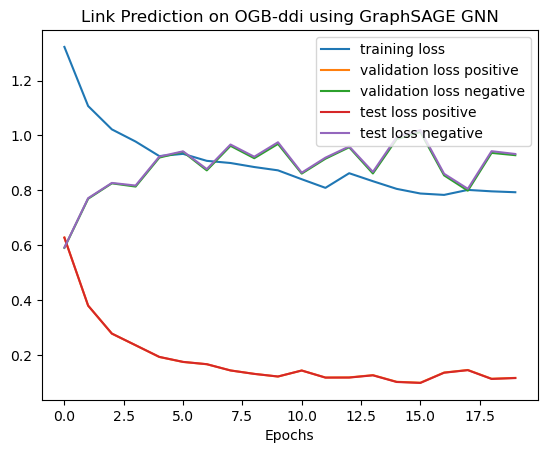

In [42]:
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(np.array(train_loss),label="training loss")
plt.plot(loss_val_pos_list,label="validation loss positive")
plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score

def calculate_roc_auc(models, split_edge, batch_size):
    
    device = 'cuda' if torch.cuda.is_available() else "cpu"

    pos_valid_edge = split_edge['valid']['edge'].T.to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].T.to(device)
    
    pos_test_edge = split_edge['test']['edge'].T.to(device)
    neg_test_edge = split_edge['test']['edge_neg'].T.to(device)

    model = models["model"]
    predictor = models["link_predictor"]
    node_emb = models["emb"].weight

    model.eval()
    predictor.eval()
    # node_emb = model(emb, edge_index)

    with torch.no_grad():

        valid_loss = []
        valid_pos_preds = []
        valid_neg_preds = []
        for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
            edge_pos = pos_valid_edge[perm].t()
            edge_neg = neg_valid_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            valid_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            valid_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            valid_loss.append(loss.item())
        
        true_labels_val = torch.cat([torch.ones(pos_valid_edge.shape[0]), torch.zeros(neg_valid_edge.shape[0])]).detach().numpy()
        pred_labels_val = torch.cat([torch.cat(valid_pos_preds), torch.cat(valid_neg_preds)]).detach().numpy()
        
        roc_auc = roc_auc_score(true_labels_val, pred_labels_val)
        print("Validation ROC AUC: ", roc_auc)
        print("Validation loss: ", sum(valid_loss) / len(valid_loss))

        test_loss = []
        test_pos_preds = []
        test_neg_preds = []
        for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
            edge_pos = pos_test_edge[perm].t()
            edge_neg = neg_test_edge[perm].t()
            pos_preds = predictor(node_emb[edge_pos[0]], node_emb[edge_pos[1]]).squeeze().cpu()
            test_pos_preds += [pos_preds]
            neg_preds = predictor(node_emb[edge_neg[0]], node_emb[edge_neg[1]]).squeeze().cpu()
            test_neg_preds += [neg_preds]
            loss = -torch.log(pos_preds + 1e-15).mean() - torch.log(1 - neg_preds + 1e-15).mean()
            test_loss.append(loss.item())

        true_labels_test = torch.cat([torch.ones(pos_test_edge.shape[0]), torch.zeros(neg_test_edge.shape[0])]).detach().numpy()
        pred_labels_test = torch.cat([torch.cat(test_pos_preds), torch.cat(test_neg_preds)]).detach().numpy()
        roc_auc = roc_auc_score(true_labels_test, pred_labels_test)
        print("Validation ROC AUC: ", roc_auc)
        print("Test loss: ", sum(test_loss) / len(test_loss))


models = {}
models["model"] = model
models["link_predictor"] = link_predictor
models["emb"] = emb
calculate_roc_auc(models, split_edge, batch_size)

Validation ROC AUC:  0.49504272455735454
Validation loss:  2.6144261801684343
Validation ROC AUC:  0.4977116399257112
Test loss:  2.603285453937672


: 

# Create UserUser dataset for GraphSAGE model

In [29]:
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE
from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from ogb.linkproppred import Evaluator
import subprocess as sp 

In [30]:
uu_dataset_graphsage = UserUserDatasetGraphSAGE(datasets_dict = datasets_dict, verbose = True)

User-article interaction dataframe created with 895196 rows
User-article interaction dataframe subsampled to 223799 rows
Graph created with 28988 nodes and 223799 edges


In [31]:
split_edge = uu_dataset_graphsage.create_train_test_split(uu_dataset_graphsage.graph.edge_index.t())

24915 4073
Train edges:  torch.Size([2, 179039])
Valid positive edges:  torch.Size([2, 22380])
Valid negative edges:  torch.Size([2, 22380])
Test positive edges:  torch.Size([2, 22380])
Test negative edges:  torch.Size([2, 22380])


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/data_loaders/data_loader_graphsage.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)],


# Run training loop

In [37]:
torch.cuda.is_available()

False

In [32]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 100
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-4
node_emb_dim = 256
batch_size = 16*1024

In [33]:
# https://colab.research.google.com/drive/1mzvskulGoM9uXCkc4Cke3_Ch0-lz_HnN#scrollTo=gG6mGvs9Uqnt

pos_train_edge = split_edge['train']['edge'].to(device)
num_nodes = len(np.unique(uu_dataset_graphsage.graph.edge_index))
emb = torch.nn.Embedding(num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

In [34]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [35]:
get_gpu_memory()

[1865]

In [36]:


evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = uu_dataset_graphsage.edge_index.to(device)

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []
hits_20 = []
hits_50 = []
hits_100 = []
roc_auc_val = []
roc_auc_test = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])
    hits_20.append(result["Hits@20"])
    hits_50.append(result["Hits@50"])
    hits_100.append(result["Hits@100"])
    roc_auc_val.append(result["roc_auc_val"])
    roc_auc_test.append(result["roc_auc_test"])

  0%|          | 0/100 [00:00<?, ?it/s]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


Train loss:  1.3838046897541394


  1%|          | 1/100 [00:10<16:33, 10.03s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.7123)
Loss val neg:  tensor(0.6586)
Loss test pos:  tensor(0.7123)
Loss test neg:  tensor(0.6581)
ROC-AUC val:  0.711553872664937
ROC-AUC test:  0.7147403159417998


100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


Train loss:  1.3034233071587302


  2%|▏         | 2/100 [00:21<18:05, 11.08s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4849)
Loss val neg:  tensor(0.7779)
Loss test pos:  tensor(0.4850)
Loss test neg:  tensor(0.7704)
ROC-AUC val:  0.7207241560789708
ROC-AUC test:  0.7252848455589975


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train loss:  1.1604977737773547


  3%|▎         | 3/100 [00:34<18:46, 11.62s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3481)
Loss val neg:  tensor(0.7619)
Loss test pos:  tensor(0.3474)
Loss test neg:  tensor(0.7523)
ROC-AUC val:  0.8198193483106404
ROC-AUC test:  0.8229691599163367


  3%|▎         | 3/100 [00:45<24:17, 15.02s/it]


KeyboardInterrupt: 

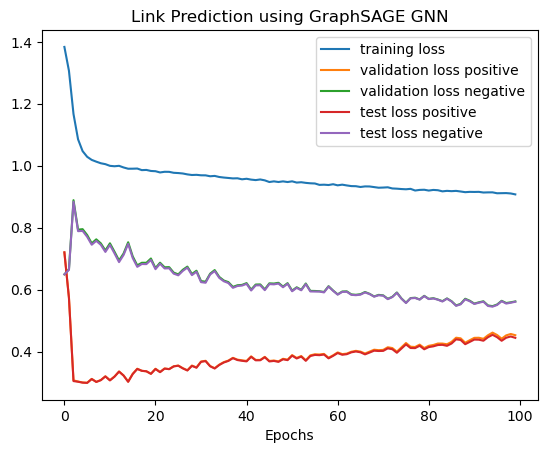

In [27]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(loss_val_pos_list,label="validation loss positive")
plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

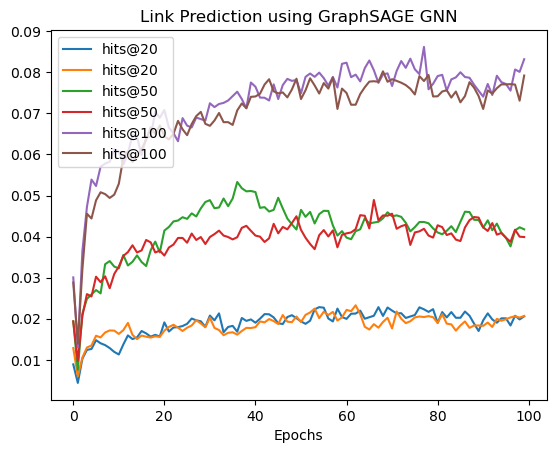

In [28]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(hits_20,label="hits@20")
plt.plot(hits_50,label="hits@50")
plt.plot(hits_100,label="hits@100")
plt.xlabel('Epochs')
plt.legend()
plt.show()

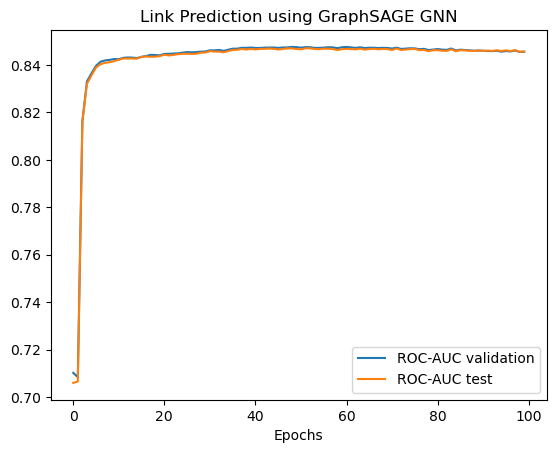

: 

In [29]:
plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(roc_auc_val,label="ROC-AUC validation")
plt.plot(roc_auc_test,label="ROC-AUC test")
plt.xlabel('Epochs')
plt.legend()
plt.show()